In [1]:
import os, time
import pandas as pd
#import codecs
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, Dataset
import spacy
import random

In [2]:
nlp = spacy.load('en_core_web_sm')

### Loading the data

In [3]:
path = "Data/"

In [4]:
df = pd.read_csv(path+'GPT-3_data_split_into_128_word_paragraphs.csv')
df = df[~df['job_segment'].isna()].reset_index()
df

,index,Unnamed: 0,job_id,job_segment,skills
0,0,0,0,SummaryThe Database Developer is part of the C...,"CEMCO, C#, database performance, .Net"
1,1,1,0,Perform database security administration.Ensur...,"C#, .Net"
2,2,2,0,"Education And/Or Experience, Certifications, R...","teamwork, Project management, SQL, T-SQL"
3,3,3,0,Physical DemandsWhile performing the duties of...,"close vision, distance vision"
4,4,4,0,"CEMCO, LLC, is the premier manufacturer of ste...","CEMCO, LLC"
...,...,...,...,...,...
6674,6686,6686,1840,Sr. Full Stack DeveloperWelcome to Beaker & Wr...,NaN
6675,6687,6687,1840,We need a full-stack developer who is a self-s...,NaN
6676,6688,6688,1840,The desired developer will head development an...,"HTML, Wordpress, Python"
6677,6689,6689,1841,"Become part of one of a large, high-performing...",CI/CD


### Converting the data to BIO tags notation

In [5]:
def get_tags(job, skills):
    try:
        doc = nlp(job)
    except:
        print(job)
    tokens  = [str(i) for i in doc]
    tags = ['O' for i in tokens]
    if type(skills) != float:
        try:
            skills = [i.strip() for i in skills.split(',')]
        except:
            print(skills)
        for skill in skills:
            for i, token in enumerate(tokens):
                if token == skill:
                    tags[i] = 'B'
                unigrams = skill.split()
                if len(unigrams) > 1:
                    if i< len(tokens)-1 and token == unigrams[0] and tokens[i+1] == unigrams[1]:
                        tags[i] = 'B'
                        tags[i+1] = 'I'
    return tokens, tags

In [6]:
tokens, tags = get_tags(df['job_segment'][0],  df['skills'][0])

for token, tag in zip(tokens, tags):
    if tag in {'B', 'I'}:
        print(token, tag)

In [7]:
all_tokens = []
all_tags = []
for job, skills in tqdm(zip(df['job_segment'], df['skills'])):
    tokens, tags = get_tags(job, skills)
    all_tokens.append(tokens)
    all_tags.append(tags)

6679it [02:27, 45.14it/s]


#### Limiting the input token length to 200 tokens

In [8]:
# Finding the longest sentence
LONGEST_SENTENCE = 200
LONGEST_SENTENCE

200

In [9]:
input_tokens, output_tags = [], []
for i, j in zip(all_tokens, all_tags):
    if len(i) <= LONGEST_SENTENCE:
        input_tokens.append(i)
        output_tags.append(j)
len(input_tokens)

5669

In [10]:
def pad_tokens(input_tokens, longest_sentence):
    padded = []
    for sent in input_tokens:
        padding = ["<null>" for i in range(longest_sentence - len(sent))]
        padded.append(sent + padding)
    return padded

def pad_tags(output_tags, longest_sentence):
    padded = []
    for sent in output_tags:
        padding = [ "<null>" for i in range(longest_sentence - len(sent))]
        padded.append(sent + padding)
    return padded


In [11]:
padded_input_tokens = pad_tokens(input_tokens[0:1], LONGEST_SENTENCE) 
padded_output_tags = pad_tags(output_tags[0:1], LONGEST_SENTENCE)

assert len(padded_input_tokens[0]) == LONGEST_SENTENCE
assert len(padded_output_tags[0]) == LONGEST_SENTENCE
assert padded_input_tokens[0][-1] == "<null>"
assert padded_output_tags[0][-1] == "<null>" 
print('Success!')

Success!


Now, we need to vectorize our input vocabulary and output tags. The code below creates a number of global variables to help us with this. 

* The `WORD_TO_IDX` dictionary maps words occurring in the training data into unique integers. 
* The `TAG_TO_IDX` dictionary maps *every* tag in our data to a unique integer. 
* The `IDX_TO_TAG` dictionary maps the other way so you can decode tags later.

In [12]:
PAD = "<null>"
UNK = "<unk>"

words = set([word for sent_words in input_tokens for word in sent_words])

# Padding and unknown token
words.add(PAD)
words.add(UNK)

tags = list(set([tag for sent_tags in output_tags for tag in sent_tags]))

# Padding tag
tags.append(PAD)

WORD_TO_IDX = {w:i for i,w in enumerate(words)}
TAG_TO_IDX = {t:i for i,t in enumerate(tags)}
IDX_TO_TAG = tags

In [13]:
len(WORD_TO_IDX)

33850

In [14]:
TAG_TO_IDX

{'B': 0, 'O': 1, 'I': 2, '<null>': 3}

In [15]:
def converttokens2tensors(input_tokens):
    '''
        Convert input_tokens into a tensor
        
        input:  A list of sentences consisting of (token, is_target_pred) pairs.
        output: A list of 2 x sentence_length tensor t
        
        where t[0][i] gives the index number for token i, t[1][i] is either 0 or 1 
        depending on is_target_pred and t[2][i] indicates whether this is a regular
        token or padding token PAD.
    '''
    token_tensors = []
    #your code here
    unk = WORD_TO_IDX["<unk>"]

    for sent in input_tokens:
        tokens = [i for i in sent]
        ids = [WORD_TO_IDX[token] if token in WORD_TO_IDX else WORD_TO_IDX['<unk>'] for token in tokens]
        pad_status = [1 if i!='<null>' else 0 for i in tokens]
        t =  torch.tensor([ids, pad_status])
        token_tensors.append(t)
    
    return token_tensors

def converttags2tensors(output_tags):
    '''
        Convert output_tags into a tensor

        input:  A list of IOB tag sequences.
        output: A list of vectors of index numbers correspinding to IOB tags 
    '''
    tag_tensors = []
    #your code here
    for sent in output_tags:
        t = torch.tensor([TAG_TO_IDX[i] for i in sent]) 
        tag_tensors.append(t)
   
    return tag_tensors

Assertions to check your code.

In [16]:
check_tokens, check_tags = converttokens2tensors(padded_input_tokens[:5]), converttags2tensors(padded_output_tags[:5])
assert check_tokens[0].shape == torch.Size([2, LONGEST_SENTENCE])
assert check_tags[0].shape == torch.Size([LONGEST_SENTENCE])
print('Success!')

Success!


### Tran, test and dev split

In [17]:
test_dev_index = random.sample(range(len(input_tokens)), 2000)
dev_index = random.sample(test_dev_index, 1000)
test_index = [i for i in test_dev_index if i not in dev_index]

In [18]:
train_input = [v for i, v in enumerate(input_tokens) if i not in test_dev_index]
train_output = [v for i, v in enumerate(output_tags) if i not in test_dev_index]

In [19]:
for i,j in zip(train_input[0], train_output[0]):
    print(i,',',j)

SummaryThe , O
Database , O
Developer , O
is , O
part , O
of , O
the , O
CEMCO , B
development , O
team , O
whose , O
responsibilities , O
include , O
managing , O
and , O
maintaining , O
the , O
enterprise , O
data , O
warehouse , O
. , O
Strong , O
development , O
skills , O
in , O
C , O
# , O
and , O
.Net , B
, , O
including , O
Excel , O
VSTO.The , O
ideal , O
candidate , O
should , O
have , O
a , O
deep , O
understanding , O
of , O
database , O
management , O
systems , O
, , O
as , O
well , O
as , O
the , O
ability , O
to , O
write , O
complex , O
code , O
in , O
C , O
# , O
and , O
.Net , B
to , O
build , O
, , O
maintain , O
and , O
optimize , O
databases , O
. , O
Effective , O
at , O
communicating , O
with , O
users , O
to , O
define , O
requirements , O
and , O
design , O
, , O
solutions , O
based , O
on , O
those , O
requirements , O
. , O
This , O
position , O
is , O
also , O
responsible , O
for , O
creating , O
tools , O
that , O
provide , O
insight , O
to , O
various , O


In [20]:
dev_input = [v for i, v in enumerate(input_tokens) if i in dev_index]
dev_output = [v for i, v in enumerate(output_tags) if i in dev_index]

test_input = [v for i, v in enumerate(input_tokens) if i in test_index]
test_output = [v for i, v in enumerate(output_tags) if i in test_index]

In [21]:
print(len(train_input), len(test_input), len(dev_input))

3669 1000 1000


In [22]:
class SRL_dataset(Dataset):
    def __init__(self, input_data, output_data):
        self.input_data = input_data
        self.output_data = output_data
        
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, index):
        target = self.output_data[index]
        data_val = self.input_data[index]
        return data_val,target     

The function below loads a set of files as a `SRL_dataset` in the correct format

In [23]:
def prepare_dataset(input_tokens, output_tags):
    '''given a list of Ontonotes SRL, loads them into a pytorch Dataset'''
    padded_input_tokens, padded_output_tokens = pad_tokens(input_tokens, LONGEST_SENTENCE), pad_tags(output_tags, LONGEST_SENTENCE)
    input_token_tensors, output_tags_tensors = converttokens2tensors(padded_input_tokens), converttags2tensors(padded_output_tokens)
    return SRL_dataset(input_token_tensors, output_tags_tensors)

Assertions to check that everything is working correctly.

In [24]:
batch_size = 64

dev_dataset = prepare_dataset(dev_input, dev_output)

dev_dataloader = DataLoader(dev_dataset, batch_size=1, shuffle=False)

train_dataset = prepare_dataset(train_input, train_output)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
for train_token_batch, train_tag_batch in train_dataloader:
    assert train_token_batch.shape == torch.Size([batch_size, 2, LONGEST_SENTENCE])
    assert train_tag_batch.shape == torch.Size([batch_size, LONGEST_SENTENCE])
    break
    
print('Success!')

Success!


### LSTM model

In [25]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Here are the embedding and hidden dimensionalities as well as LSTM layer count
EMBEDDING_DIM=75
HIDDEN_DIM=50
LAYERS=1

# your code here
class biLSTMTagger(nn.Module):

    def __init__(self, vocab, tagset):
        super(biLSTMTagger, self).__init__()

        # requires vocab, tagset; 

        self.word_embeddings = nn.Embedding(len(vocab), EMBEDDING_DIM)       # `Embedding` with `len(vocab)` with EMBEDDING_DIM; 
        #self.indicator_embedding = nn.Embedding(2, EMBEDDING_DIM)   # another `Embedding` for "indicator_embedding (len(0 or 1)) == 2) with EMBEDDING_DIM ; 
        #self.lstm = nn.LSTM(2 * EMBEDDING_DIM, HIDDEN_DIM, num_layers=LAYERS, bidirectional = True)                       # `LSTM` with 2 * EMBEDDING_DIM, HIDDEN_DIM, and bidrectional = True

        #self.hidden2tag = nn.Linear(2 * HIDDEN_DIM, len(tagset))               # The linear layer that maps from hidden state space to tag space (output = len(tagset))
        
        #self.indicator_embedding = nn.Embedding(2, EMBEDDING_DIM)   # another `Embedding` for "indicator_embedding (len(0 or 1)) == 2) with EMBEDDING_DIM ; 
        self.lstm = nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, num_layers=LAYERS, bidirectional = True)                       # `LSTM` with 2 * EMBEDDING_DIM, HIDDEN_DIM, and bidrectional = True

        self.hidden2tag = nn.Linear(2 * HIDDEN_DIM, len(tagset)) 
        
        
    def forward(self, batch):
        batch = batch.permute(1, 2, 0)  # required to be permuted: 3 x sent_len x batch_size

        #embeds_word = self.word_embeddings(batch[0])
        #embeds_ind = self.word_embeddings(batch[1])
        #embeds = torch.cat((embeds_word, embeds_ind), dim=2)                        # sent_len x batch_size x 2*EMBEDDING_DIM
        embeds = self.word_embeddings(batch[0])
        word_lengths = batch[-1].sum(dim=0)
        lstm_input =  pack_padded_sequence(embeds, word_lengths, enforce_sorted=False)                            # requires `pack_padded_sequence`
 
        lstm_out, _ = self.lstm(lstm_input)                        # sent_len x batch_size x 2*HIDDEN_DIM
        lstm_out, _ =  pad_packed_sequence(lstm_out, total_length = LONGEST_SENTENCE)                          # requires again `pack_padded_sequence` 
        
        tag_space =  self.hidden2tag(lstm_out)                               # generated by `hidden2tag`: sent_len x batch_size x tagset_size
        tag_scores = F.log_softmax(tag_space, dim=2)                # then, softmax; 

        return tag_scores

An assertion to check your code:

In [26]:
tagger = biLSTMTagger(WORD_TO_IDX, TAG_TO_IDX)
batch = next(iter(train_dataloader))[0]
assert tagger(batch).size() == (batch.size()[2], batch_size, len(TAG_TO_IDX))

In [27]:
# your code here
EPOCHS = 20 
model = biLSTMTagger(WORD_TO_IDX, TAG_TO_IDX)
loss_function = nn.CrossEntropyLoss(weight = torch.tensor([0.5, 0.05, 0.4, 0.05]))
optimizer = optim.SGD(model.parameters(), lr=5)

In [28]:
TAG_TO_IDX

{'B': 0, 'O': 1, 'I': 2, '<null>': 3}

### training

In [29]:
BATCH_SIZE = 64
SENT_PER_BATCH = 4


for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}")
    tot_loss = 0
    model.train()
    for sent_batch, tag_batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        tag_scores = model(sent_batch)
        tag_scores = tag_scores.permute(1, 2, 0)
        loss = loss_function(tag_scores, tag_batch)
        loss.backward()
        optimizer.step()
        tot_loss += loss.item()
    # Print the average loss per sentence for the epoch
    avg_loss = tot_loss / (len(train_dataloader) * BATCH_SIZE * SENT_PER_BATCH)
    targets = []
    preds = []
    for sent_batch, tag_batch in dev_dataloader:
        targets.extend(tag_batch[0].tolist())
        tag_scores = model(sent_batch)
        tag_scores = tag_scores.argmax(axis=2).squeeze().tolist()
        preds.extend(tag_scores)
    preds = [IDX_TO_TAG[i] for i in preds] 
    targets = [IDX_TO_TAG[i] for i in targets]
    print(f"Avg loss per sentence: {avg_loss}")
    print('macro f1 score for dev data:',f1_score(targets,preds, average='macro'))

Epoch 1


100%|███████████████████████████████████████████| 58/58 [00:22<00:00,  2.57it/s]


Avg loss per sentence: 0.0013678073561910924
macro f1 score for dev data: 0.6242859476425062
Epoch 2


100%|███████████████████████████████████████████| 58/58 [00:22<00:00,  2.53it/s]


Avg loss per sentence: 0.000740359704901368
macro f1 score for dev data: 0.6832209577213689
Epoch 3


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.51it/s]


Avg loss per sentence: 0.0006237992206949677
macro f1 score for dev data: 0.6915326292365429
Epoch 4


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.50it/s]


Avg loss per sentence: 0.0005502616936453329
macro f1 score for dev data: 0.6966632140913931
Epoch 5


100%|███████████████████████████████████████████| 58/58 [00:22<00:00,  2.52it/s]


Avg loss per sentence: 0.0004968399920597158
macro f1 score for dev data: 0.7025203124447804
Epoch 6


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.50it/s]


Avg loss per sentence: 0.00045592273065643704
macro f1 score for dev data: 0.7016768713259433
Epoch 7


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.52it/s]


Avg loss per sentence: 0.0004229824974980398
macro f1 score for dev data: 0.7033686123167607
Epoch 8


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.47it/s]


Avg loss per sentence: 0.00039620090909262093
macro f1 score for dev data: 0.7048522180410199
Epoch 9


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.48it/s]


Avg loss per sentence: 0.0003726921294683366
macro f1 score for dev data: 0.7059419251702775
Epoch 10


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.50it/s]


Avg loss per sentence: 0.00035180548980735755
macro f1 score for dev data: 0.7070491463930506
Epoch 11


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.51it/s]


Avg loss per sentence: 0.00033252839032151124
macro f1 score for dev data: 0.7056881740437919
Epoch 12


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.50it/s]


Avg loss per sentence: 0.0003146832881109982
macro f1 score for dev data: 0.705796933661043
Epoch 13


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.52it/s]


Avg loss per sentence: 0.0002978550910484046
macro f1 score for dev data: 0.7117955436353198
Epoch 14


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.50it/s]


Avg loss per sentence: 0.0002819597199238066
macro f1 score for dev data: 0.7132882376681751
Epoch 15


100%|███████████████████████████████████████████| 58/58 [00:22<00:00,  2.53it/s]


Avg loss per sentence: 0.00026676785085422535
macro f1 score for dev data: 0.7122583753446399
Epoch 16


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.50it/s]


Avg loss per sentence: 0.0002521750720916316
macro f1 score for dev data: 0.7128424675062279
Epoch 17


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.45it/s]


Avg loss per sentence: 0.0002380918697875539
macro f1 score for dev data: 0.7110352079533475
Epoch 18


100%|███████████████████████████████████████████| 58/58 [05:24<00:00,  5.59s/it]


Avg loss per sentence: 0.00022449417407062418
macro f1 score for dev data: 0.7087573159762011
Epoch 19


100%|███████████████████████████████████████████| 58/58 [00:22<00:00,  2.54it/s]


Avg loss per sentence: 0.0002114651013408579
macro f1 score for dev data: 0.710602044811448
Epoch 20


100%|███████████████████████████████████████████| 58/58 [05:22<00:00,  5.57s/it]


Avg loss per sentence: 0.00019915215094003762
macro f1 score for dev data: 0.7118814201305476


## Test performance

In [30]:
test_dataset = prepare_dataset(test_input, test_output)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [31]:
targets = []
preds = []
for sent_batch, tag_batch in test_dataloader:
    targets.extend(tag_batch[0].tolist())
    tag_scores = model(sent_batch)
    tag_scores = tag_scores.argmax(axis=2).squeeze().tolist()
    preds.extend(tag_scores)
preds = [IDX_TO_TAG[i] for i in preds] 
targets = [IDX_TO_TAG[i] for i in targets]
print('macro f1 score for test data:',f1_score(targets,preds, average='macro'))

macro f1 score for test data: 0.7213589842627985


In [66]:
print(classification_report(targets,preds, labels=['B', 'I', 'O']))

              precision    recall  f1-score   support

           B       0.46      0.52      0.49      1652
           I       0.42      0.39      0.40       396
           O       0.99      0.99      0.99    129245

   micro avg       0.98      0.98      0.98    131293
   macro avg       0.63      0.63      0.63    131293
weighted avg       0.98      0.98      0.98    131293



In [62]:
cm = confusion_matrix(targets,preds)

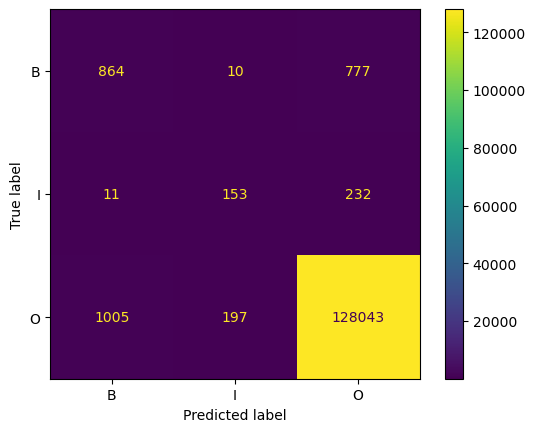

In [65]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm[1:,1:],
                             display_labels = ['B', 'I', 'O'])
disp.plot()


In [74]:
## Some manual testing

def get_skills(sentence_list):
    prediction = []
    token_list = []
    tag_list = []
    for sentence in sentence_list:
        if type(sentence) == str:
            doc = nlp(sentence)
            tokens = [str(i) for i in doc]
            output = ['O' for i in range(len(tokens))]
            tokens = tokens[:200]
            token_list.append(tokens)
            tag_list.append(output)
    dataset = prepare_dataset(token_list, tag_list)
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    preds = []
    for sent_batch, tag_batch in loader:
        tag_scores = model(sent_batch)
        tag_scores = tag_scores.argmax(axis=2).squeeze().tolist()
        preds = [IDX_TO_TAG[i] for i in tag_scores] 
        prediction.append(preds)
    #result = []
    
    entity_list = []
    for i, p in enumerate(prediction):
        tokens = token_list[i]
        entity = ''
        entities = []
        for j in range(len(p)):
            if p[j] == 'B':
                if entity != '':
                    entities.append(entity)
                entity = tokens[j]
            elif p[j] == 'I':
                if entity != '':
                    entity += ' '+tokens[j]
            else:
                if entity != '':
                    entities.append(entity)
                entity = ''
        entity_list.append(entities)
        
        #result.append([(t,j) for t, j in zip(tokens, p) if j in {'B', 'I'}])
    return  entity_list

sentence = ['We need someone who is good at Python and Java.',
            
'Good with machine learning. Excellent Azure knowledge. Good with data science and NLP',
            ]
for i,j in zip(sentence,get_skills(sentence)):
    print('Input:',i)
    print('Skills:',j)
    print()

Input: We need someone who is good at Python and Java.
Skills: ['Python', 'Java']

Input: Good with machine learning. Excellent Azure knowledge. Good with data science and NLP
Skills: ['Azure', 'data science', 'NLP']



In [75]:
sentence_list = [df['job_segment'][i] for i in test_index if type(df['job_segment'][i])==str]
gold = [df['skills'][i] for i in test_index if type(df['job_segment'][i])==str]

In [76]:
gold[-10:]

[nan,
 nan,
 'business, Engineering, technology',
 nan,
 nan,
 'EVC, monitors, Cybersecurity Engineer',
 'Business Analytics',
 nan,
 'Nimble',
 'Research Engineer, Machine Learning']

In [77]:
predictions = get_skills(sentence_list)

In [78]:
predictions[-10:]

[[],
 [],
 ['Beeline'],
 ['Big', 'NLP'],
 [],
 ['Cybersecurity',
  'Cybersecurity',
  'EVC',
  'monitors',
  'Cybersecurity',
  'business'],
 ['data', 'business', 'data'],
 [],
 ['AI', 'AI'],
 ['Machine Learning']]

In [79]:
def evaluate(gold, pred):
    gold_count = 0
    pred_count = 0
    TP = 0
    for i,j in zip(gold, pred):
        if type(i) != str:
            i = set()
        else:
            i = set([s.strip().lower() for s in i.split(',')])
        j = set([i.lower() for i in j])
        TP += len(i.intersection(j))
        gold_count += len(i)
        pred_count += len(j)
    prec = TP / pred_count
    recall = TP / gold_count
    f1 = 2 * prec * recall / (prec + recall)
    return prec, recall, f1

evaluate(gold, predictions)

(0.41523605150214593, 0.5375, 0.4685230024213075)

### Testing our model on human annotated data

In [80]:
import re

def jd_clean(job):
    return ' '.join(re.split(r'[\'\"], [\'\"]', job[2:-2]))

df_eval = pd.read_csv('final_annotated_data.csv')
df_eval['job'] = df_eval['job_description'].apply(jd_clean)

In [81]:
df_eval.head()

,url,title,job_description,seniority_level,employment_type,skills,class_name,experience,job
0,https://www.linkedin.com/jobs/view/full-stack-...,Full Stack Software Engineer,['SpaceX was founded under the belief that a f...,Entry level,Full-time,"sql,python,server,react,database,scala,c#.net,...",full_stack_engineer,junior,SpaceX was founded under the belief that a fut...
1,https://www.linkedin.com/jobs/view/associate-d...,Intermediate Full-Stack Web Developer (C#/MSSQ...,['Splashdot is looking for a Intermediate Full...,Not Applicable,Full-time,"asp net,asp.net,sql,c#,server,realm,html/css,r...",full_stack_engineer,intermediate,Splashdot is looking for a Intermediate Full-S...
2,https://www.linkedin.com/jobs/view/associate-d...,Frontend Software Engineer,"[""ResponsibilitiesFounded in 2012, ByteDance's...",Mid-Senior level,Full-time,"ambiguity,sql,server,swift,broadcasting,react,...",full_stack_engineer,intermediate,"ResponsibilitiesFounded in 2012, ByteDance's m..."
3,https://www.linkedin.com/jobs/view/associate-d...,Full Stack Engineer,['About The JobTome is building across a broad...,Entry level,Full-time,"postgresql,typescript,react,node",full_stack_engineer,junior,About The JobTome is building across a broad s...
4,https://www.linkedin.com/jobs/view/associate-d...,Full Stack Developer (Remote),['MonetizeMore builds industry-leading ad tech...,Mid-Senior level,Full-time,"git,python,react,deployment,node,linux,ruby,sc...",full_stack_engineer,intermediate,MonetizeMore builds industry-leading ad techno...


In [82]:
nlp = spacy.load('en_core_web_sm')


def get_token_number(text):
    doc = nlp(text)
    return len([i for i in doc])


def sentence_segmentation(job_desc):
    """
    This function return a list of sentences for a job description
    """
    doc = nlp(job_desc)
    return [sent for sent in doc.sents]


def get_paras(sents, skills_list, limit = 128):
    '''
    Converts a list of sentences to a list of paragraphs (so that we could limit the number of API calls to some extent)
    '''
    num_token = 0
    paragraphs = []
    sub_skills = []
    para = ''
    for sent in sents:
        sent = sent.text
        num_token += get_token_number(sent)
        if num_token >= limit:
            paragraphs.append(para)
            sub_skills.append(', '.join([i for i in skills_list if i in para.lower()]))
            para = ''
            num_token = 0
        para += ' ' + sent
    paragraphs.append(para)
    sub_skills.append(', '.join([i for i in skills_list if i in para]))
    return paragraphs, sub_skills

In [642]:
paras_list = []
skills_list = []
job_id = []
i = 0
for job, skills in tqdm(zip(df_eval['job'], df_eval['skills'])):
    sents = sentence_segmentation(job)
    skills_list_temp = [i.strip() for i in skills.split(',')]
    paras, skill = get_paras(sents, skills_list_temp, limit = 128)
    paras_list.extend(paras)
    skills_list.extend(skill)
    job_id.extend([i for j in range(len(skill))])
    i+=1

278it [00:48,  5.75it/s]


In [643]:
df_split = pd.DataFrame({'job_id': job_id, 'job_segment':paras_list, 'skills':skills_list})
df_split

,job_id,job_segment,skills
0,0,SpaceX was founded under the belief that a fu...,"software, go"
1,0,"We design, build, test, and operate all parts...","software, engineering"
2,0,"On this team, we will rely on you to be a key...",software
3,0,"Develop well-architected, responsive, and per...","sql, python, server, react, database, scala, c..."
4,0,Base salary is just one part of your total re...,
...,...,...,...
1085,276,We work to build each other up and support on...,
1086,276,"Throughout the year, the advantage of being p...",
1087,277,Cybersecurity Specialist â€“ Network and Comm...,
1088,277,This role will give you the opportunity to in...,"iso, nist, iam"


In [651]:
df_split = df_split[df_split['job_segment']!='']

In [652]:
%%time
pred_skills = get_skills(df_split['job_segment'].tolist())

CPU times: user 25 s, sys: 259 ms, total: 25.2 s
Wall time: 25.4 s


In [659]:
df_split['prediction'] = [','.join(p).lower() for p in pred_skills]

/var/folders/10/1dfn6jyd4m1chbgpv0qm29nw0000gn/T/ipykernel_26741/1370963735.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_split['prediction'] = [','.join(p).lower() for p in pred_skills]


In [677]:
TP = 0
len_gold = 0
len_pred = 0
for i in df_split['job_id'].unique():
    temp = df_split[df_split['job_id']==i]
    gold = ','.join(temp['skills'])
    pred = ','.join(temp['prediction'])
    gold = set([i.strip() for i in gold.split(',') if i.strip()!=''])
    pred = set([i.strip() for i in pred.split(',') if i.strip()!=''])
    TP += len(gold.intersection(pred))
    len_gold += len(gold)
    len_pred += len(pred)
prec = TP / len_pred
recall = TP / len_gold
f1 = 2 * prec * recall / (prec + recall)
print('Precision:', prec)
print('Recall:', recall)
print('F1:', f1)

Precision: 0.27315914489311166
Recall: 0.23354995938261575
F1: 0.2518064374863148


## Adding more features to LSTM

In [128]:
all_inputs = []
all_tags = []
for job, skills in tqdm(zip(df['job_segment'], df['skills'])):
    tokens, tags = get_tags(job, skills)
    inputs = [(i, int(i.istitle()), int(i.isupper()), int(i.islower())) for i in tokens]
    all_inputs.append(inputs)
    all_tags.append(tags)

6679it [04:36, 24.13it/s]


In [129]:
input_tokens, output_tags = [], []
for i, j in zip(all_inputs, all_tags):
    if len(i) <= LONGEST_SENTENCE:
        input_tokens.append(i)
        output_tags.append(j)
len(input_tokens)

5669

In [130]:
input_tokens[0][:5]

[('SummaryThe', 0, 0, 0),
 ('Database', 1, 0, 0),
 ('Developer', 1, 0, 0),
 ('is', 0, 0, 1),
 ('part', 0, 0, 1)]

In [131]:
def pad_tokens(input_tokens, longest_sentence):
    padded = []
    for sent in input_tokens:
        padding = [("<null>", "<null>", "<null>", "<null>") for i in range(longest_sentence - len(sent))]
        padded.append(sent + padding)
    return padded

In [132]:
def converttokens2tensors(input_tokens):
    '''
        Convert input_tokens into a tensor
        
        input:  A list of sentences consisting of (token, is_target_pred) pairs.
        output: A list of 2 x sentence_length tensor t
        
        where t[0][i] gives the index number for token i, t[1][i] is either 0 or 1 
        depending on is_target_pred and t[2][i] indicates whether this is a regular
        token or padding token PAD.
    '''
    token_tensors = []
    #your code here
    unk = WORD_TO_IDX["<unk>"]

    for sent in input_tokens:
        tokens = [i[0] for i in sent]
        is_title = [i[1] if i[1]!='<null>' else 2 for i in sent]
        is_capital = [i[2] if i[2]!='<null>' else 2 for i in sent]
        is_lower = [i[3] if i[3]!='<null>' else 2 for i in sent]
        ids = [WORD_TO_IDX[token] if token in WORD_TO_IDX else WORD_TO_IDX['<unk>'] for token in tokens]
        pad_status = [1 if i[0]!='<null>' else 0 for i in tokens]
        #print(ids, is_title, is_capital, is_lower, pad_status)
        t =  torch.tensor([ids, is_title, is_capital, is_lower, pad_status])
        token_tensors.append(t)
    
    return token_tensors

In [133]:
train_input = [v for i, v in enumerate(input_tokens) if i not in test_dev_index]
train_output = [v for i, v in enumerate(output_tags) if i not in test_dev_index]

dev_input = [v for i, v in enumerate(input_tokens) if i in dev_index]
dev_output = [v for i, v in enumerate(output_tags) if i in dev_index]

test_input = [v for i, v in enumerate(input_tokens) if i in test_index]
test_output = [v for i, v in enumerate(output_tags) if i in test_index]

In [134]:
batch_size = 64

dev_dataset = prepare_dataset(dev_input, dev_output)

dev_dataloader = DataLoader(dev_dataset, batch_size=1, shuffle=False)

train_dataset = prepare_dataset(train_input, train_output)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
for train_token_batch, train_tag_batch in train_dataloader:
    assert train_token_batch.shape == torch.Size([batch_size, 5, LONGEST_SENTENCE])
    assert train_tag_batch.shape == torch.Size([batch_size, LONGEST_SENTENCE])
    break
    
print('Success!')

Success!


In [135]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Here are the embedding and hidden dimensionalities as well as LSTM layer count
EMBEDDING_DIM=75
SMALL_EMBEDDING_DIM = 5
HIDDEN_DIM=50
LAYERS=1

# your code here
class biLSTMTagger(nn.Module):

    def __init__(self, vocab, tagset):
        super(biLSTMTagger, self).__init__()

        # requires vocab, tagset; 

        self.word_embeddings = nn.Embedding(len(vocab), EMBEDDING_DIM)       # `Embedding` with `len(vocab)` with EMBEDDING_DIM; 
        self.title_embedding = nn.Embedding(3, SMALL_EMBEDDING_DIM)   # another `Embedding` for "indicator_embedding (len(0 or 1)) == 2) with EMBEDDING_DIM ; 
        self.capital_embedding = nn.Embedding(3, SMALL_EMBEDDING_DIM)
        self.lower_embedding = nn.Embedding(3, SMALL_EMBEDDING_DIM)
        #self.lstm = nn.LSTM(2 * EMBEDDING_DIM, HIDDEN_DIM, num_layers=LAYERS, bidirectional = True)                       # `LSTM` with 2 * EMBEDDING_DIM, HIDDEN_DIM, and bidrectional = True

        #self.hidden2tag = nn.Linear(2 * HIDDEN_DIM, len(tagset))               # The linear layer that maps from hidden state space to tag space (output = len(tagset))
        
        #self.indicator_embedding = nn.Embedding(2, EMBEDDING_DIM)   # another `Embedding` for "indicator_embedding (len(0 or 1)) == 2) with EMBEDDING_DIM ; 
        self.lstm = nn.LSTM(EMBEDDING_DIM + 3 * SMALL_EMBEDDING_DIM, HIDDEN_DIM, num_layers=LAYERS, bidirectional = True)                       # `LSTM` with 2 * EMBEDDING_DIM, HIDDEN_DIM, and bidrectional = True

        self.hidden2tag = nn.Linear(2 * HIDDEN_DIM, len(tagset)) 
        
        
    def forward(self, batch):
        batch = batch.permute(1, 2, 0)  # required to be permuted: 3 x sent_len x batch_size

        #embeds_word = self.word_embeddings(batch[0])
        #embeds_ind = self.word_embeddings(batch[1])
        #embeds = torch.cat((embeds_word, embeds_ind), dim=2)                        # sent_len x batch_size x 2*EMBEDDING_DIM
        embeds_word = self.word_embeddings(batch[0])
        embeds_title = self.title_embedding(batch[1])
        embeds_capital = self.capital_embedding(batch[2])
        embeds_lower = self.lower_embedding(batch[3])
        embeds = torch.cat((embeds_word, embeds_title, embeds_capital, embeds_lower), dim=2) 
        word_lengths = batch[-1].sum(dim=0)
        lstm_input =  pack_padded_sequence(embeds, word_lengths, enforce_sorted=False)                            # requires `pack_padded_sequence`
 
        lstm_out, _ = self.lstm(lstm_input)                        # sent_len x batch_size x 2*HIDDEN_DIM
        lstm_out, _ =  pad_packed_sequence(lstm_out, total_length = LONGEST_SENTENCE)                          # requires again `pack_padded_sequence` 
        
        tag_space =  self.hidden2tag(lstm_out)                               # generated by `hidden2tag`: sent_len x batch_size x tagset_size
        tag_scores = F.log_softmax(tag_space, dim=2)                # then, softmax; 

        return tag_scores

In [136]:
# your code here
EPOCHS = 20 
model = biLSTMTagger(WORD_TO_IDX, TAG_TO_IDX)
loss_function = nn.CrossEntropyLoss(weight = torch.tensor([0.5, 0.05, 0.4, 0.05]))
optimizer = optim.SGD(model.parameters(), lr=5)

In [ ]:
BATCH_SIZE = 64
SENT_PER_BATCH = 4


for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}")
    tot_loss = 0
    model.train()
    for sent_batch, tag_batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        tag_scores = model(sent_batch)
        tag_scores = tag_scores.permute(1, 2, 0)
        loss = loss_function(tag_scores, tag_batch)
        loss.backward()
        optimizer.step()
        tot_loss += loss.item()
    # Print the average loss per sentence for the epoch
    avg_loss = tot_loss / (len(train_dataloader) * BATCH_SIZE * SENT_PER_BATCH)
    targets = []
    preds = []
    for sent_batch, tag_batch in dev_dataloader:
        targets.extend(tag_batch[0].tolist())
        tag_scores = model(sent_batch)
        tag_scores = tag_scores.argmax(axis=2).squeeze().tolist()
        preds.extend(tag_scores)
    preds = [IDX_TO_TAG[i] for i in preds] 
    targets = [IDX_TO_TAG[i] for i in targets]
    print(f"Avg loss per sentence: {avg_loss}")
    print('macro f1 score for dev data:',f1_score(targets,preds, average='macro'))

Epoch 1


100%|███████████████████████████████████████████| 58/58 [00:22<00:00,  2.52it/s]


Avg loss per sentence: 0.0009753545846565273
macro f1 score for dev data: 0.6809434989551382
Epoch 2


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.48it/s]


Avg loss per sentence: 0.0005921428543435217
macro f1 score for dev data: 0.6868706368049946
Epoch 3


100%|███████████████████████████████████████████| 58/58 [00:22<00:00,  2.59it/s]


Avg loss per sentence: 0.0005179991517095538
macro f1 score for dev data: 0.7013654005184906
Epoch 4


100%|███████████████████████████████████████████| 58/58 [00:22<00:00,  2.59it/s]


Avg loss per sentence: 0.0004683632116588154
macro f1 score for dev data: 0.7163325157490211
Epoch 5


100%|███████████████████████████████████████████| 58/58 [00:22<00:00,  2.59it/s]


Avg loss per sentence: 0.00043179755849795864
macro f1 score for dev data: 0.7223161863263432
Epoch 6


100%|███████████████████████████████████████████| 58/58 [00:22<00:00,  2.60it/s]


Avg loss per sentence: 0.0004028752109975201
macro f1 score for dev data: 0.7255407828625914
Epoch 7


100%|███████████████████████████████████████████| 58/58 [00:25<00:00,  2.27it/s]


Avg loss per sentence: 0.00037854696560755437
macro f1 score for dev data: 0.7256003732229488
Epoch 8


100%|███████████████████████████████████████████| 58/58 [00:26<00:00,  2.20it/s]


Avg loss per sentence: 0.0003572873854487813
macro f1 score for dev data: 0.7297349937426335
Epoch 9


100%|███████████████████████████████████████████| 58/58 [00:25<00:00,  2.25it/s]


Avg loss per sentence: 0.00033819863943037866
macro f1 score for dev data: 0.7316558243687872
Epoch 10


100%|███████████████████████████████████████████| 58/58 [00:25<00:00,  2.23it/s]


Avg loss per sentence: 0.00032078668200170044
macro f1 score for dev data: 0.7329995213754446
Epoch 11


100%|███████████████████████████████████████████| 58/58 [00:26<00:00,  2.18it/s]


Avg loss per sentence: 0.0003048359127394084
macro f1 score for dev data: 0.7321786597580635
Epoch 12


100%|███████████████████████████████████████████| 58/58 [00:24<00:00,  2.41it/s]


Avg loss per sentence: 0.0002900862941871686
macro f1 score for dev data: 0.733333613755833
Epoch 13


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.44it/s]


Avg loss per sentence: 0.0002763107253925008
macro f1 score for dev data: 0.7348903715021269
Epoch 14


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.47it/s]


Avg loss per sentence: 0.00026338166684707114
macro f1 score for dev data: 0.7352347105778164
Epoch 15


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.45it/s]


Avg loss per sentence: 0.00025122299848590046
macro f1 score for dev data: 0.7373859048713871
Epoch 16


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.52it/s]


Avg loss per sentence: 0.00023968720704252864
macro f1 score for dev data: 0.7403956627335065
Epoch 17


100%|███████████████████████████████████████████| 58/58 [00:24<00:00,  2.40it/s]


Avg loss per sentence: 0.00022870327816706086
macro f1 score for dev data: 0.7426532053855673
Epoch 18


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.46it/s]


Avg loss per sentence: 0.0002182245163943474
macro f1 score for dev data: 0.7431266775152627
Epoch 19


100%|███████████████████████████████████████████| 58/58 [00:23<00:00,  2.50it/s]


Avg loss per sentence: 0.00020818718584105853
macro f1 score for dev data: 0.7442813949334465
Epoch 20


100%|███████████████████████████████████████████| 58/58 [00:25<00:00,  2.31it/s]


Avg loss per sentence: 0.00019854516308285007
macro f1 score for dev data: 0.7458872962798395


# Test performance

In [143]:
test_dataset = prepare_dataset(test_input, test_output)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [144]:
targets = []
preds = []
for sent_batch, tag_batch in test_dataloader:
    targets.extend(tag_batch[0].tolist())
    tag_scores = model(sent_batch)
    tag_scores = tag_scores.argmax(axis=2).squeeze().tolist()
    preds.extend(tag_scores)
preds = [IDX_TO_TAG[i] for i in preds] 
targets = [IDX_TO_TAG[i] for i in targets]
print('macro f1 score for test data:',f1_score(targets,preds, average='macro'))

macro f1 score for test data: 0.7343961409167863


In [145]:
print(classification_report(targets,preds, labels=['B', 'I', 'O']))

              precision    recall  f1-score   support

           B       0.44      0.55      0.49      1682
           I       0.41      0.52      0.46       405
           O       0.99      0.99      0.99    129879

   micro avg       0.98      0.98      0.98    131966
   macro avg       0.61      0.69      0.65    131966
weighted avg       0.98      0.98      0.98    131966



In [146]:
## Some manual testing

def get_skills(sentence_list):
    prediction = []
    token_list = []
    tag_list = []
    for sentence in sentence_list:
        doc = nlp(sentence)
        tokens = [(str(i), int(str(i).istitle()),int(str(i).isupper()), int(str(i).islower())) for i in doc]
        output = ['O' for i in range(len(tokens))]
        tokens = tokens[:200]
        token_list.append(tokens)
        tag_list.append(output)
    dataset = prepare_dataset(token_list, tag_list)
    loader = DataLoader(dataset, batch_size=1, shuffle=False)
    preds = []
    for sent_batch, tag_batch in loader:
        tag_scores = model(sent_batch)
        tag_scores = tag_scores.argmax(axis=2).squeeze().tolist()
        preds = [IDX_TO_TAG[i] for i in tag_scores] 
        prediction.append(preds)
    #result = []
    
    entity_list = []
    for i, p in enumerate(prediction):
        tokens = [w[0] for w in token_list[i]]
        entity = ''
        entities = []
        for j in range(len(p)):
            if p[j] == 'B':
                if entity != '':
                    entities.append(entity)
                entity = tokens[j]
            elif p[j] == 'I':
                if entity != '':
                    entity += ' '+tokens[j]
            else:
                if entity != '':
                    entities.append(entity)
                entity = ''
        entity_list.append(entities)
        
        #result.append([(t,j) for t, j in zip(tokens, p) if j in {'B', 'I'}])
    return  entity_list

sentence = ['We need someone who is good at Python and Java.',
            'We need someone who is good at python and java.',
            
'Good with machine learning. Excellent Azure knowledge. Good with data science and NLP',
            ]
for i,j in zip(sentence,get_skills(sentence)):
    print('Input:',i)
    print('Skills:',j)
    print()

Input: We need someone who is good at Python and Java.
Skills: ['Python', 'Java']

Input: We need someone who is good at python and java.
Skills: ['python']

Input: Good with machine learning. Excellent Azure knowledge. Good with data science and NLP
Skills: ['machine learning', 'Azure', 'data science']



In [148]:
%%time
predictions = get_skills(sentence_list)
predictions[:5]

CPU times: user 27.8 s, sys: 442 ms, total: 28.2 s
Wall time: 28.2 s


[['data'], [], [], [], ['Racing', 'AWS']]

In [149]:
evaluate(gold, predictions)

(0.3787076271186441, 0.5088967971530249, 0.43425447919829946)